In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()

print(os.listdir()) 

success = load_dotenv()
print(f"dotenv loaded: {success}")

os.environ["TAVILY_API_KEY"] =  os.getenv("TVLY_API_KEY")

['chatbot.ipynb', '.ipynb_checkpoints']
dotenv loaded: True


In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2) 
tools = [tool]

tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [3]:
# 2. Add a node
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import os 

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

# 1. Create a StateGraph
class State(TypedDict):
    messages: Annotated[list,add_messages]

# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
import json 
from langchain_core.messages import ToolMessage

class BasicToolNode: 
    """A node that runs the tools requested in the last AIMessage."""
    def __init__(self,tools:list)->None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self,inputs:dict): 
        if messages := inputs.get('messages',[]):
            message = messages[-1]
        else: 
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls: 
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append( 
                ToolMessage( 
                    content=json.dumps(tool_result),
                    name=tool_call['name'], 
                    tool_call_id=tool_call['id'], 
                )
            )
        return {"messages":outputs}

tool_node = BasicToolNode(tools=[tool]) 

graph_builder.add_node("tools",tool_node)

In [6]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [8]:
graph = graph_builder.compile(checkpointer=memory)

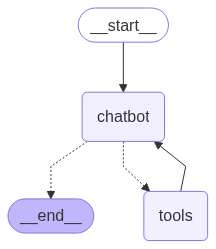

In [9]:
# Visualize the graph(optional)
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error: {e}")

In [12]:
config = {"configurable": {"thread_id": "1"}}

In [13]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will, nice to meet you! Is there anything I can help you with today?


In [14]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": "Yeah, I would like to learn about Langraph and Langsmith how both works together"}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yeah, I would like to learn about Langraph and Langsmith how both works together
================================== Ai Message ==================================
Tool Calls:
  tavily_search (83fd4fad-c7a9-4951-810d-faf395e18189)
 Call ID: 83fd4fad-c7a9-4951-810d-faf395e18189
  Args:
    search_depth: advanced
    query: Langraph and Langsmith how they work together
================================= Tool Message =================================
Name: tavily_search

{"query": "Langraph and Langsmith how they work together", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.stackademic.com/langchain-langgraph-and-langsmith-the-trio-for-building-agentic-ai-apps-9da1b653a65f", "title": "LangChain, LangGraph, and LangSmith: The Trio for Building ...", "content": "A Unified Ecosystem: How LangChain, LangGraph, and LangSmith Work Together\n\nIndividually, LangChain, Lan

In [15]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='84fc1ed5-ddea-4aa3-80fa-17c6579c8c5f'), AIMessage(content='Hi Will, nice to meet you! Is there anything I can help you with today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2f7fee03-97b6-4d08-b0c0-3c67ca4cf983-0', usage_metadata={'input_tokens': 491, 'output_tokens': 19, 'total_tokens': 510, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03485c-291b-6400-8001-f0cc43279285'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='Hi Will, nice to meet you! Is there anything I can help you with today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'saf